In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
import gym
import gym.spaces
import stable_baselines3 as sb3
from stable_baselines3 import PPO
from skopt import gp_minimize
from skopt.space import Integer, Real

Extract Market Pattern Features

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ta.volatility import BollingerBands


# Step 1: Download the data
data = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')

# Step 2: Compute indicators
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(window=10).std()

# Step 3: Create the prediction target
data['Target'] = data['Close'].shift(-3)  # Predict 3 days ahead
data.dropna(inplace=True)

# Step 5: Feature selection
features = ['SMA_10', 'SMA_50', 'RSI_14', 'MACD', 'Volatility']
X = data[features].values
y = data['Target'].values.reshape(-1, 1)

# Step 6: Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Step 7: Sequence formatting for LSTM-like models
sequence_length = 3
X_reshaped = np.array([X_scaled[i-sequence_length:i] for i in range(sequence_length, len(X_scaled))])
y_reshaped = y_scaled[sequence_length:]

split = int(0.9 * len(X_reshaped))
X_train, X_test = X_reshaped[:split], X_reshaped[split:]
y_train, y_test = y_reshaped[:split], y_reshaped[split:]

# Final sanity check
print("X_reshaped shape:", X_test.shape)
print("y_reshaped shape:", y_test.shape)


[*********************100%***********************]  1 of 1 completed


X_reshaped shape: (372, 3, 5)
y_reshaped shape: (372, 1)


Creating LSTM model with units: 64 and dropout rate: 0.2 for sequence length: 3 and num features: 5
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1025 - mae: 0.2559 
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mae: 0.1163
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - mae: 0.0743
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - mae: 0.0388
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - mae: 0.0344
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mae: 0.0329
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0305  
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0294
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0297
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0289
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 0.0274
Epoc

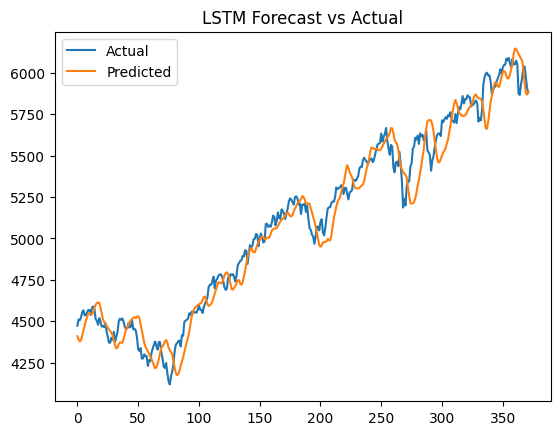

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        query, value = inputs, inputs
        score = tf.matmul(query, tf.transpose(value, [0, 2, 1]))
        attention_weights = tf.nn.softmax(score, axis=-1)
        context_vector = tf.matmul(attention_weights, value)
        return context_vector

def create_lstm_model(units, dropout_rate, sequence_length, num_features):
    print("Creating LSTM model with units:", units, "and dropout rate:", dropout_rate, "for sequence length:", sequence_length, "and num features:", num_features)
    inputs = Input(shape=(sequence_length, num_features))
    x = LSTM(units, kernel_initializer='glorot_uniform', return_sequences=True)(inputs)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


sequence_length = 3
num_features = X_train.shape[2]  # e.g., 12

lstm_model = create_lstm_model(units=64, dropout_rate=0.2,
                               sequence_length=sequence_length,
                               num_features=num_features)

lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

preds = lstm_model.predict(X_test)
preds_rescaled = scaler_y.inverse_transform(preds)
y_true = scaler_y.inverse_transform(y_test)

plt.plot(y_true, label='Actual')
plt.plot(preds_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()


In [ ]:
import gym
import numpy as np
from gym import spaces
from skopt import gp_minimize
from skopt.space import Real, Integer

class TradingEnv(gym.Env):
    """Custom Trading Environment for Reinforcement Learning."""
    def __init__(self, data, lstm_model, scaler_X, scaler_y):
        super(TradingEnv, self).__init__()
        self.data = data
        self.lstm_model = lstm_model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.current_step = 0
        self.action_space = spaces.Discrete(3)  # 0: Buy, 1: Hold, 2: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        """Resets the environment to the initial state."""
        self.current_step = 3
        return np.array([self.get_forecast()], dtype=np.float32)

    def step(self, action):
        """Executes a step in the environment based on the selected action."""
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        reward = self.calculate_reward(action)
        obs = np.array([self.get_forecast()], dtype=np.float32) if not done else np.zeros(1)
        return obs, reward, done, {}

    def get_forecast(self):
        # Get the last 3 time steps of data (for prediction)
        features = ['SMA_10', 'SMA_50', 'RSI_14', 'MACD', 'Volatility']
        recent_data = self.data.iloc[self.current_step - 3:self.current_step]

        if len(recent_data) < 3:
            return 0.0  # not enough data to forecast

        # Scale recent data — assumes scaler is already fitted on full data (or features)
        recent_scaled = self.scaler_X.transform(recent_data.values)  # shape (3, num_features)

        # Ensure correct shape: (1, sequence_length, num_features)
        input_seq = recent_scaled.reshape(1, recent_scaled.shape[0], recent_scaled.shape[1])
        #print("Input seq shape :", input_seq.shape)

        forecast = self.lstm_model.predict(input_seq, verbose=0)
        return self.scaler_y.inverse_transform(forecast)[0][0]

    def calculate_reward(self, action):
        future_price = self.data['Close'].iloc[self.current_step + 1].item() if self.current_step < len(self.data) - 1 else self.data['Close'].iloc[self.current_step].item()
        current_price = self.data['Close'].iloc[self.current_step].item()

        if action == 0:  # Buy
            return future_price - current_price
        elif action == 1:  # Hold
            return 0.0
        else:  # Sell
            return current_price - future_price

def ppo_objective(params):
    print("Model input shape:", lstm_model.input_shape)  # <-- must be (None, 3, 12)
    learning_rate, n_steps, gamma, clip_range, batch_size = params

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_X.fit(X)
    scaler_y.fit(y)

    # Create env using the fitted scaler
    env = TradingEnv(data, lstm_model, scaler_X, scaler_y)

    # Train PPO
    model = PPO('MlpPolicy', env, verbose=0, learning_rate=learning_rate,
                n_steps=n_steps, gamma=gamma, clip_range=clip_range,  batch_size=batch_size)
    model.learn(total_timesteps=5000)

    # Evaluate with random rollout
    rewards = []
    obs = env.reset()
    for _ in range(100):
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break

    return -np.mean(rewards)  # Minimize the negative mean reward

# Define hyperparameter search space for PPO
ppo_space = [
    Real(0.0001, 0.01, name='learning_rate'),  # Learning rate for PPO optimizer
    Integer(1024, 2048, name='n_steps'),  # Number of steps before PPO updates
    Real(0.9, 0.999, name='gamma'),  # Discount factor for future rewards
    Real(0.1, 0.4, name='clip_range'),  # Clipping range for PPO updates
    Integer(101, 606, name='batch_size')   # Batch size for PPO updates
]

# Call Bayesian Optimization on the PPO objective function
best_ppo_params = gp_minimize(ppo_objective, ppo_space, n_calls=10, random_state=42)


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 191, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1212`, after every 6 untruncated mini-batches, there will be a truncated mini-batch of size 66
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1212 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 232, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1494`, after every 6 untruncated mini-batches, there will be a truncated mini-batch of size 102
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1494 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 301, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1763`, after every 5 untruncated mini-batches, there will be a truncated mini-batch of size 258
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1763 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 207, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1650`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 201
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1650 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 119, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1072`, after every 9 untruncated mini-batches, there will be a truncated mini-batch of size 1
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1072 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 275, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1416`, after every 5 untruncated mini-batches, there will be a truncated mini-batch of size 41
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1416 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 215, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1485`, after every 6 untruncated mini-batches, there will be a truncated mini-batch of size 195
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1485 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 239, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1040`, after every 4 untruncated mini-batches, there will be a truncated mini-batch of size 84
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1040 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 138, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1877`, after every 13 untruncated mini-batches, there will be a truncated mini-batch of size 83
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1877 and n_envs=1)
  warnings.warn(


Model input shape: (None, 3, 12)


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 107, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1459`, after every 13 untruncated mini-batches, there will be a truncated mini-batch of size 68
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1459 and n_envs=1)
  warnings.warn(


In [122]:
best_learning_rate, best_n_steps, best_gamma, best_clip_range , batchsd = best_ppo_params.x
env = TradingEnv(data, lstm_model, scaler_X= scaler_X, scaler_y=scaler_y)
dl_model = PPO('MlpPolicy', env, verbose=1, learning_rate=best_learning_rate, n_steps=best_n_steps, gamma=best_gamma, clip_range=best_clip_range)
dl_model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/SYDE675/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1763`, after every 27 untruncated mini-batches, there will be a truncated mini-batch of size 35
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1763 and n_envs=1)
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 40   |
|    iterations      | 1    |
|    time_elapsed    | 43   |
|    total_timesteps | 1763 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 2            |
|    time_elapsed         | 87           |
|    total_timesteps      | 3526         |
| train/                  |              |
|    approx_kl            | 0.0027971321 |
|    clip_fraction        | 0.0699       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 4.71e-05     |
|    learning_rate        | 0.000658     |
|    loss                 | 906          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000131    |
|    value_loss           | 1.61e+03     |
------------------------------------------
----------------

In [125]:
def classify_trend(reward):
    if reward > 0.01:
        return 2  # Market going up
    elif reward < -0.01:
        return 0  # Market going down
    else:
        return 1  # Market sideways / neutral


Action: 2, Reward: -8.36, Market Trend: 0
Action: 1, Reward: 0.00, Market Trend: 1
Action: 1, Reward: 0.00, Market Trend: 1
Action: 0, Reward: 0.86, Market Trend: 2
Action: 0, Reward: 6.63, Market Trend: 2
Action: 1, Reward: 0.00, Market Trend: 1
Action: 0, Reward: -3.84, Market Trend: 0
Action: 2, Reward: -8.67, Market Trend: 0
Action: 2, Reward: -9.34, Market Trend: 0
Action: 1, Reward: 0.00, Market Trend: 1
Action: 2, Reward: 6.99, Market Trend: 2
Action: 1, Reward: 0.00, Market Trend: 1
Action: 0, Reward: 7.93, Market Trend: 2
Action: 1, Reward: 0.00, Market Trend: 1
Action: 2, Reward: -0.82, Market Trend: 0
Action: 0, Reward: 13.35, Market Trend: 2
Action: 2, Reward: -1.02, Market Trend: 0
Action: 0, Reward: -19.54, Market Trend: 0
Action: 2, Reward: -5.39, Market Trend: 0
Action: 2, Reward: -9.65, Market Trend: 0
Action: 2, Reward: 1.23, Market Trend: 2
Action: 0, Reward: 2.73, Market Trend: 2
Action: 1, Reward: 0.00, Market Trend: 1
Action: 2, Reward: 5.23, Market Trend: 2
Actio

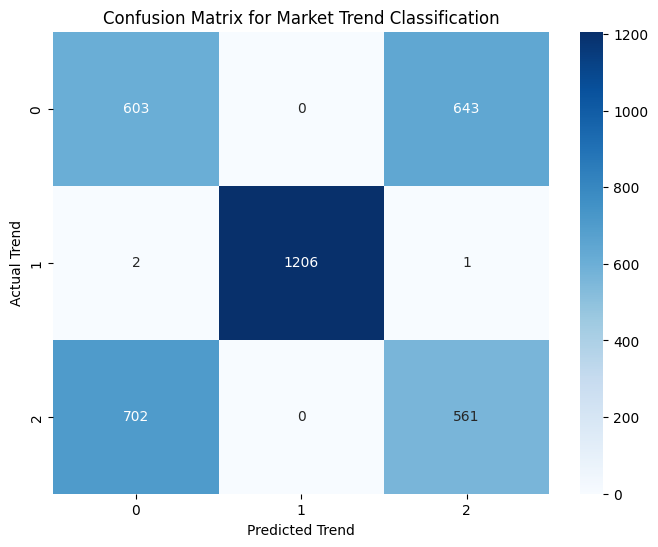

              precision    recall  f1-score   support

        Down       0.46      0.48      0.47      1246
     Neutral       1.00      1.00      1.00      1209
          Up       0.47      0.44      0.45      1263

    accuracy                           0.64      3718
   macro avg       0.64      0.64      0.64      3718
weighted avg       0.64      0.64      0.64      3718



In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


# Step 7: Evaluate RL Model and Visualize Results
done = False
obs = env.reset()
actual_trends = []
predicted_trends = []

while not done:
    action, _states = dl_model.predict(obs)
    obs, reward, done, info = env.step(action)
    
    # Determine true trend based on reward
    trend = classify_trend(reward)  # should return 0 (down), 1 (neutral), or 2 (up)
    
    actual_trends.append(trend)
    predicted_trends.append(int(action))  # ensure compatibility with confusion matrix

    print(f"Action: {action}, Reward: {reward:.2f}, Market Trend: {trend}")

# Step 8: Visualization - Confusion Matrix
plt.figure(figsize=(8, 6))
conf_mat = pd.crosstab(
    pd.Series(actual_trends, name='Actual'),
    pd.Series(predicted_trends, name='Predicted')
)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Market Trend Classification')
plt.xlabel('Predicted Trend')
plt.ylabel('Actual Trend')
plt.show()

print(classification_report(actual_trends, predicted_trends, target_names=['Down', 'Neutral', 'Up']))
